In [103]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os 
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



import pathlib
!drive clone 'https://drive.google.com/drive/folders/1Ps7sLZt42dCeBGW7TMvyRhXzu3ZDaCHH?usp=sharing'
import os
print(len(os.listdir("/content/drive/MyDrive/training_data")))




/bin/bash: drive: command not found
12


In [100]:
#in case there are 13 classes (because of hidden class .ipynb_checkpoints) Compile it!
#import shutil
#shutil.rmtree("/content/drive/MyDrive/training_data/.ipynb_checkpoints")

In [104]:
import pathlib
import tensorflow as tf
dataset_url = 'https://drive.google.com/drive/folders/1Ps7sLZt42dCeBGW7TMvyRhXzu3ZDaCHH?usp=sharing'
data_dir = tf.keras.utils.get_file('/content/drive/MyDrive/training_data', origin= dataset_url)
BATCH_SIZE = 16
IMG_SIZE = (224,224)
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,shuffle=True,batch_size=BATCH_SIZE,image_size= IMG_SIZE)

 


Found 963 files belonging to 12 classes.


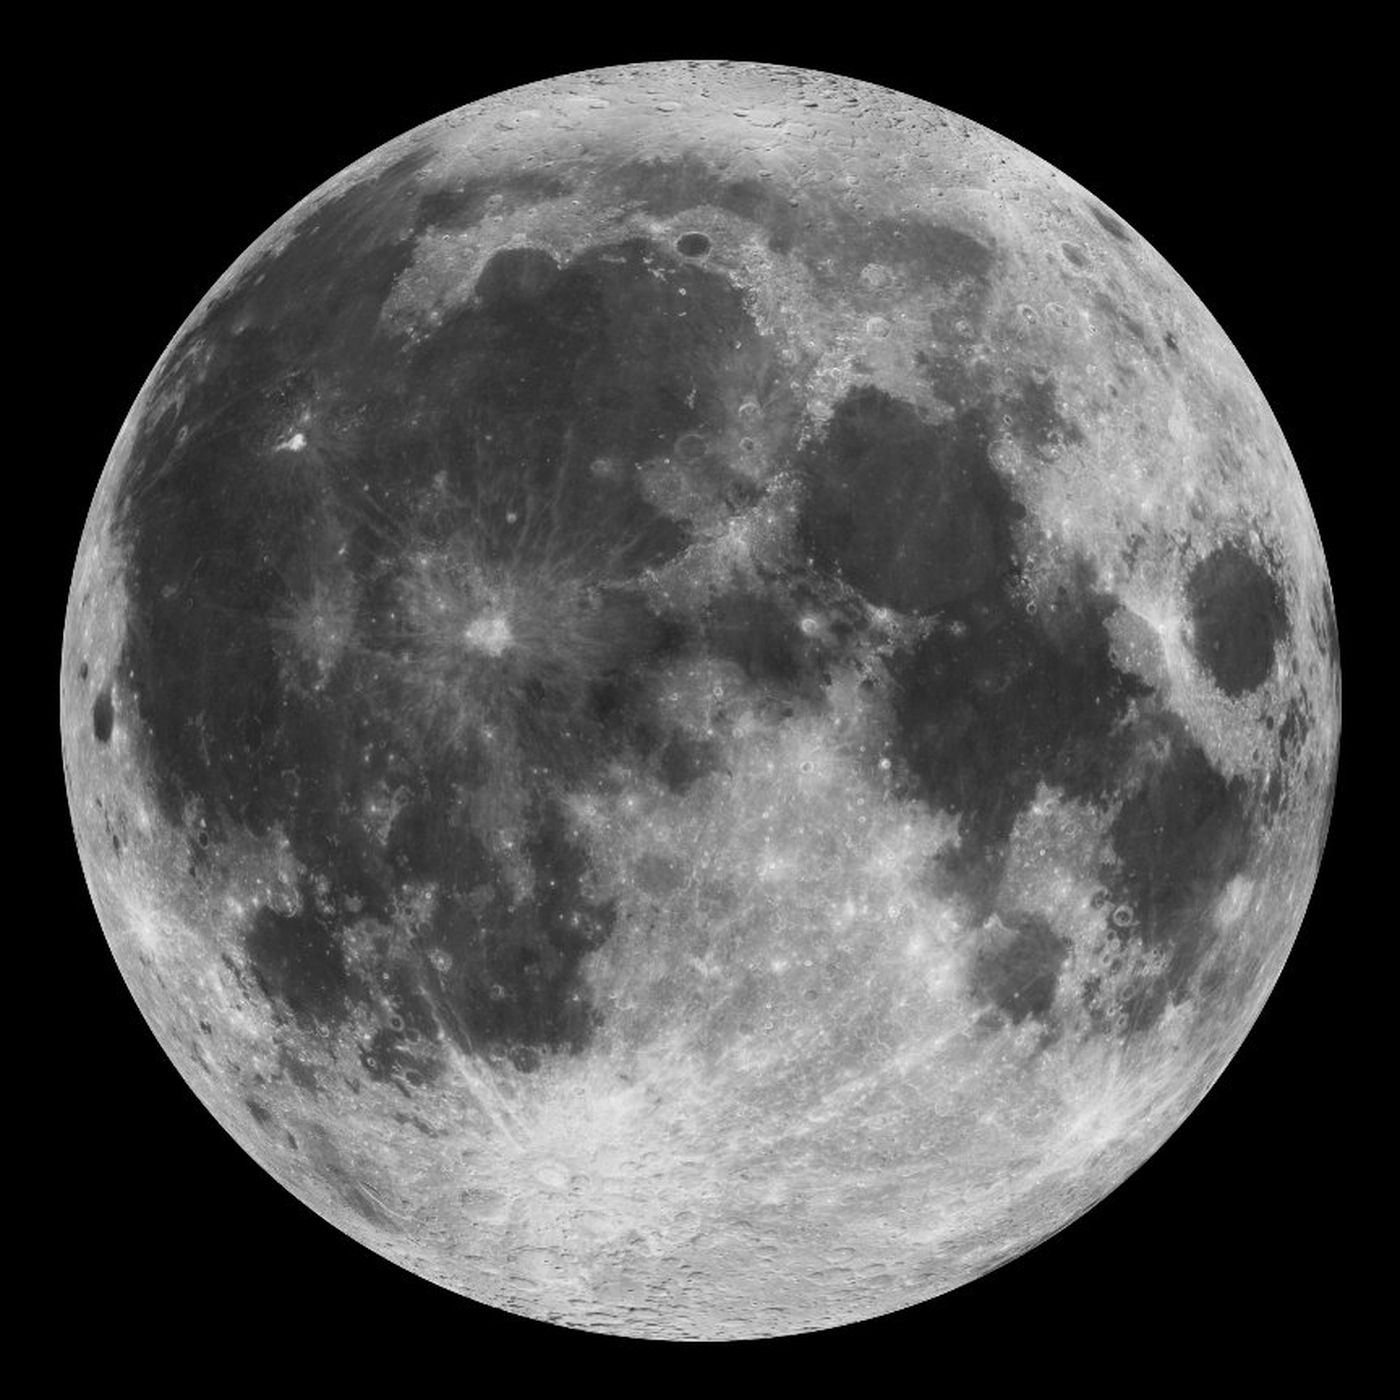

In [105]:
data_dir = pathlib.Path(data_dir)
moon = list(data_dir.glob('moon/*'))
earth = list(data_dir.glob('earth/*'))

PIL.Image.open(str(moon[0]))

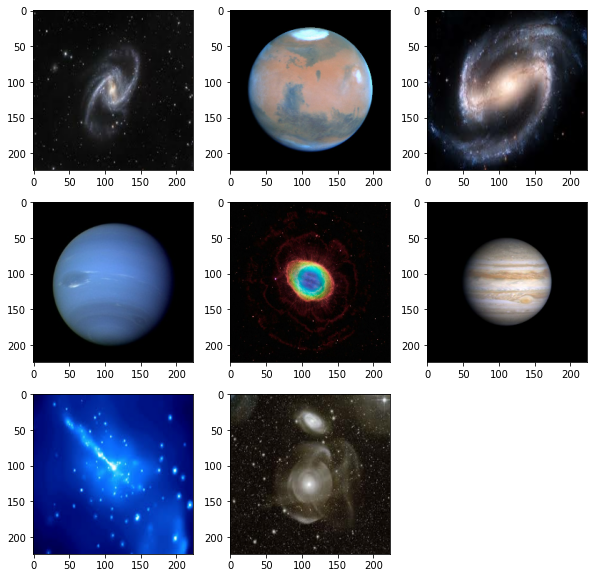

(0.0, 1.0, 0.0, 1.0)

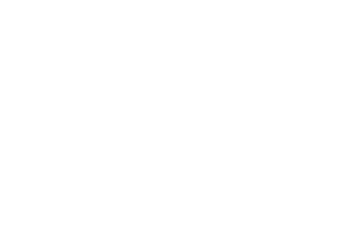

In [106]:
import matplotlib.pyplot as plt       
import matplotlib.image as mpimg 


plt.figure(figsize=(10, 10))

for image_batch,label_batch in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3,3,i + 1)
    plt.imshow(image_batch[i]/255.0)

plt.show()  
plt.axis("off")

In [107]:
print(image_batch.shape)
normalization_layer = layers.Rescaling(1./255)

(16, 224, 224, 3)


In [108]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [112]:
class_names = train_ds.class_names
print(class_names)

['Nebulae', 'earth', 'elliptical', 'jupiter', 'mars', 'mercury', 'moon', 'neptune', 'saturn', 'spiral', 'uranus', 'venus']


In [113]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [114]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [115]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 56, 56, 64)      

In [116]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir, validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=16)

Found 963 files belonging to 12 classes.
Using 192 files for validation.


In [117]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(224,224,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

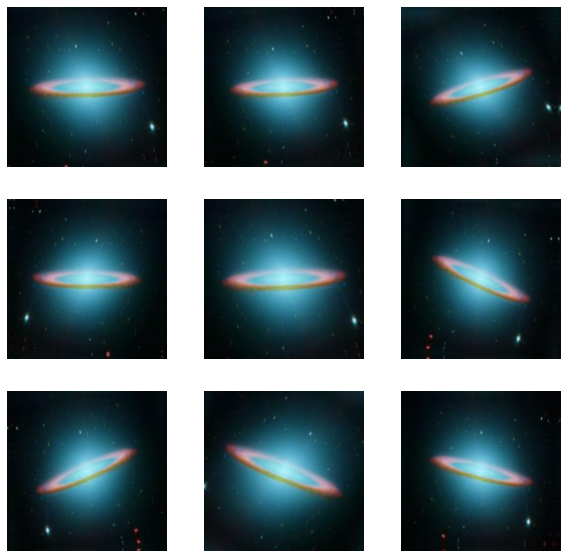

In [118]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [119]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [120]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [121]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_16 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                

In [122]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
61/61 [==============================] - 64s 1s/step - loss: 1.8434 - accuracy: 0.3551 - val_loss: 1.2900 - val_accuracy: 0.5208
Epoch 2/15
61/61 [==============================] - 63s 1s/step - loss: 1.2597 - accuracy: 0.5421 - val_loss: 1.3672 - val_accuracy: 0.5365
Epoch 3/15
61/61 [==============================] - 62s 1s/step - loss: 0.9941 - accuracy: 0.6407 - val_loss: 1.1063 - val_accuracy: 0.5938
Epoch 4/15
61/61 [==============================] - 62s 998ms/step - loss: 0.8495 - accuracy: 0.6885 - val_loss: 0.7472 - val_accuracy: 0.7188
Epoch 5/15
61/61 [==============================] - 62s 997ms/step - loss: 0.8097 - accuracy: 0.6874 - val_loss: 0.6319 - val_accuracy: 0.7552
Epoch 6/15
61/61 [==============================] - 62s 1s/step - loss: 0.6658 - accuracy: 0.7456 - val_loss: 0.5930 - val_accuracy: 0.7448
Epoch 7/15
61/61 [==============================] - 61s 994ms/step - loss: 0.6144 - accuracy: 0.7612 - val_loss: 0.4446 - val_accuracy: 0.8125
Epoch 8/15


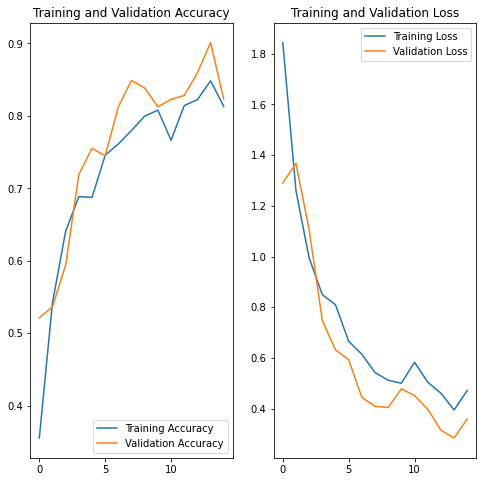

In [123]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [125]:
# test data (https://drive.google.com/drive/folders/10F0G92sPhh5dxiGgJYrO5nV7-VD24V77?usp=sharing)

Celestial_url = "https://github.com/ritwik12/Celestial-bodies-detection/blob/master/hub/examples/image_retraining/test_data/neptune/000.jpg"
Celestial_path = tf.keras.utils.get_file('/content/drive/MyDrive/test_data/neptune/000.jpg', origin =Celestial_url)

img = tf.keras.utils.load_img(Celestial_path, target_size=(224,224))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

if np.max(score)<0.6 :
  print("This image is not related to any Class")
else:
 print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to neptune with a 99.88 percent confidence.
